Resumen del proceso detallado:

https://github.com/aleju/papers/blob/master/neural-nets/A_Neural_Algorithm_for_Artistic_Style.md

In [0]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Carga del modelo preentrenado VGG19

---



In [2]:
vgg = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
for param in vgg.parameters():
  param.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#Carga de imágenes

In [0]:
def load_image(path, max_size=400, shape=None):
  image = Image.open(path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size=shape

  in_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))
  ])

  image =  in_transform(image).unsqueeze(0)
  return image

In [0]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape= content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 599.5, 399.5, -0.5)

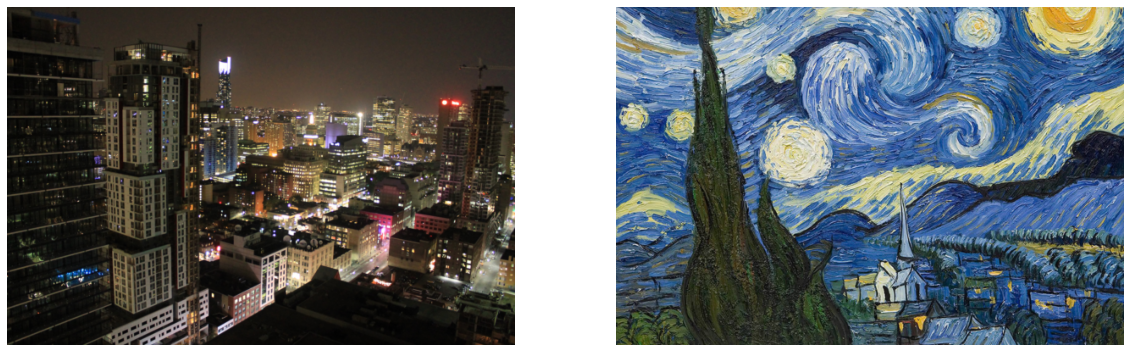

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')


#Extracción de Features


In [0]:
def get_features(image, model):
   
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {}
 
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features


content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

# Calculo de la matrix GRAM

La matrix GRAM símplemente se da multiplicando (Producto matricial) una matriz por su transpuesta.  g = m * mT

In [0]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


Vamos a calcular la matrix GRAM para cada uno de los features de estilo extraidos por la función get_features()

Lo guardamos como un diccionario, donde la llave es el índice de la capa layer, y el valor es el resultado de la función gram_matrix() aplicada a los features de la capa.

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

No todas las capas convolucionales serán usadas para la extracción de estilo, solo las marcadas para esta tarea.

Las primeras capas de una CNN siempre son mejores para captar los estilos (Texturas y patrones) de una imagen.

Por eso entre más temprana sea la capa, mayor peso debería tener a la hora del proceso de extracción de texturas.

In [0]:
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
 
content_weight = 1  # alpha
style_weight = 1e6  # beta

No partiremos desde una imagen aleatoria (ruido blanco) sino desde una copia de la imagen original para que el optimizador intente mantener el contenido de esta.

In [0]:
target = content.clone().requires_grad_(True).to(device)


# Proceso de Optimización

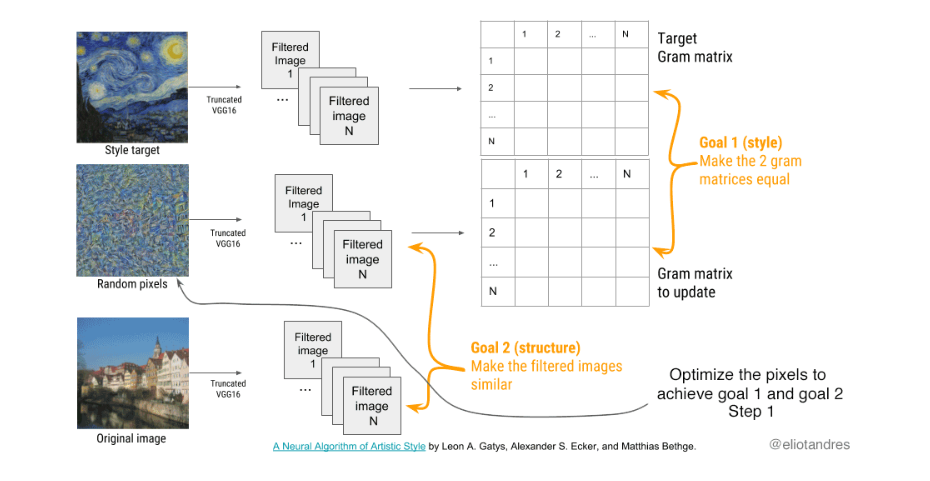!

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  2887779.0
Iteration:  300


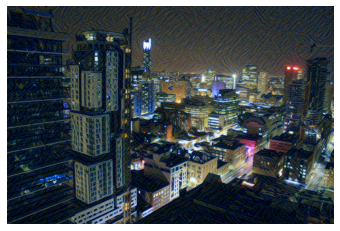

Total loss:  949784.125
Iteration:  600


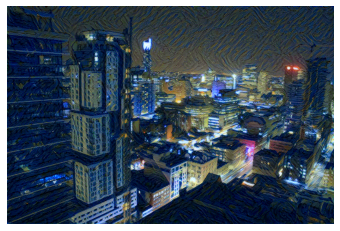

Total loss:  658375.8125
Iteration:  900


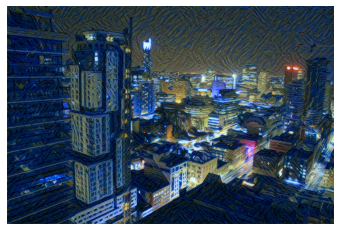

Total loss:  510381.125
Iteration:  1200


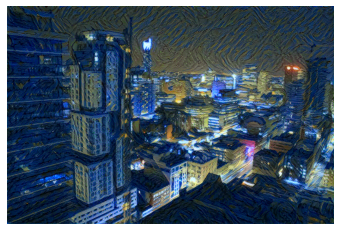

Total loss:  400738.59375
Iteration:  1500


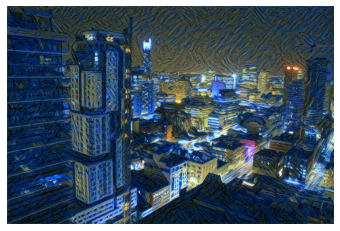

Total loss:  315010.65625
Iteration:  1800


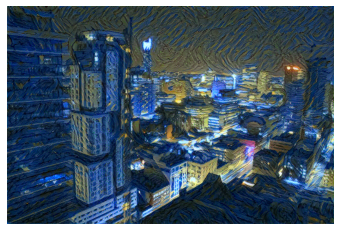

Total loss:  246979.6875
Iteration:  2100


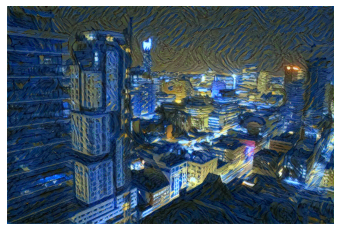

In [15]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

(-0.5, 599.5, 399.5, -0.5)

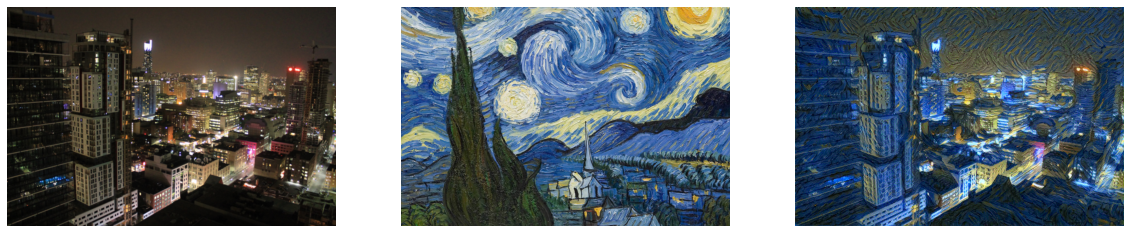

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

#Exportar el proceso como un video

In [0]:
import cv2

In [0]:

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0,300):
  img = image_array[i]
  img = img * 255
  img = np.array(img, dtype=np.uint8) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [0]:
from google.colab import files

files.download('output.mp4')